In [6]:
# 导入相关库
import numpy as np
import pandas as pd
import pytz
import rqdatac
import datetime as dt
import matplotlib.pyplot as plt
import os

start_date = 20150101
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

rqdatac.init()

RB_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="RB",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

HC_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="HC",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

d:\gitrepo\FICC_QIS\venv\Lib\site-packages\rqdatac\client.py:218: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
d:\gitrepo\FICC_QIS\venv\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  13 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


In [7]:
RB_prices = (RB_df["open"] + RB_df["close"]) / 2
HC_prices = (HC_df["open"] + HC_df["close"]) / 2


spread_df = pd.DataFrame(
    {
        "HC_prices": HC_prices.droplevel(level=0),
        "RB_prices": RB_prices.droplevel(level=0),
    }
)

# 计算价差
spread_df["RB-HC"] = RB_prices.droplevel(level=0) - HC_prices.droplevel(level=0)

# 计算移动均值和标准差
window = 20
spread_df["MEAN"] = spread_df["RB-HC"].rolling(window=window, min_periods=1).mean()
spread_df["SD"] = spread_df["RB-HC"].rolling(window=window, min_periods=1).std()
spread_df["Z_SCORE"] = (spread_df["RB-HC"] - spread_df["MEAN"]) / spread_df["SD"]

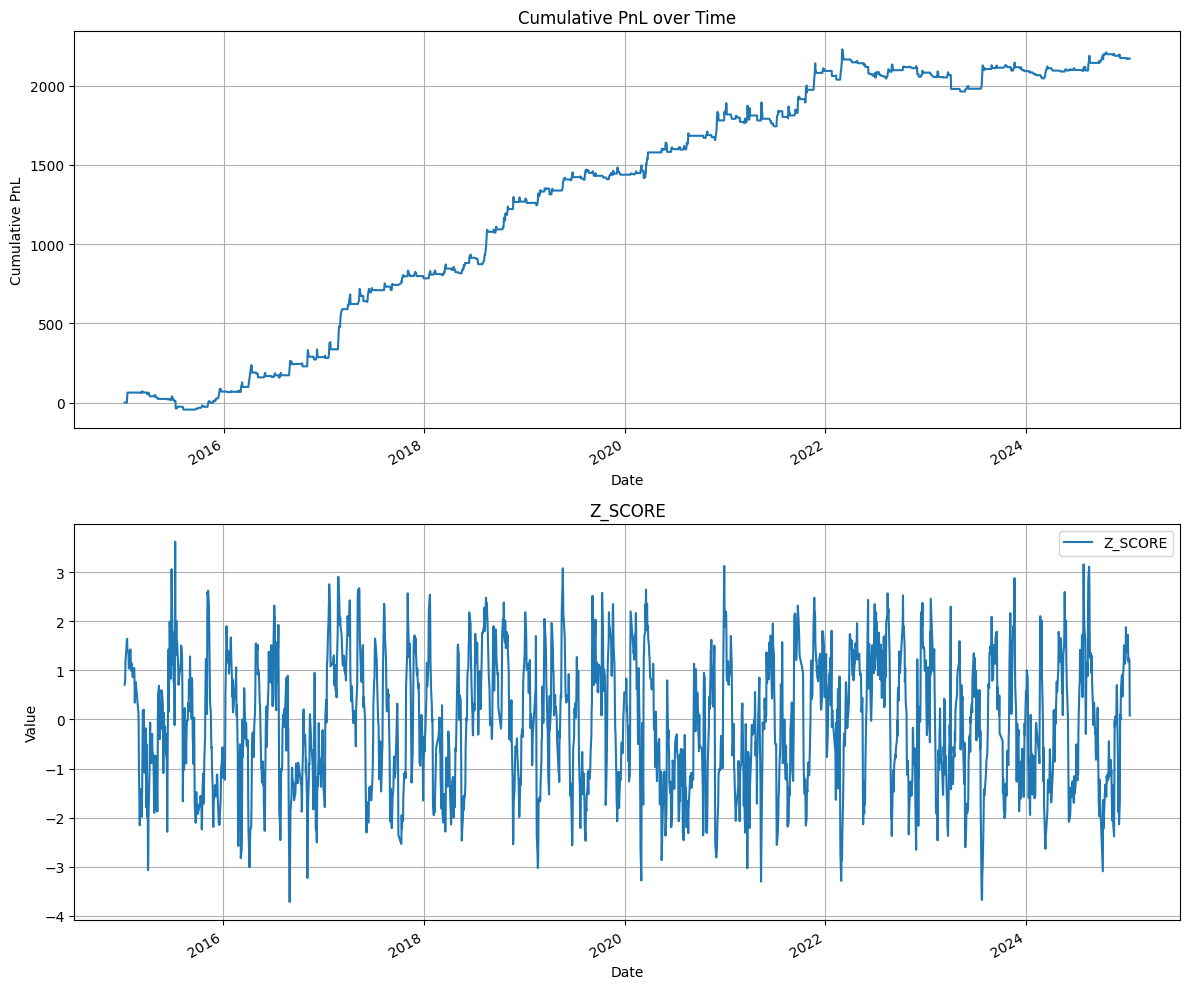

In [8]:
# 初始化持仓状态
spread_df["POSITION_HC"] = 0
spread_df["POSITION_RB"] = 0
# 记录每日持仓和盈亏
spread_df["PNL"] = 0
spread_df["CUM_PNL"] = 0

# 策略调整
entry_threshold = 1.5
exit_threshold = 1

for i in range(len(spread_df)):
    if spread_df.iloc[i]["Z_SCORE"] < -entry_threshold:
        # 价差过大，卖出T，买入两手TF
        spread_df.at[spread_df.index[i], "POSITION_HC"] += -1
        spread_df.at[spread_df.index[i], "POSITION_RB"] += 1
    elif spread_df.iloc[i]["Z_SCORE"] > entry_threshold:
        # 价差过小，买入T，卖出两手TF
        spread_df.at[spread_df.index[i], "POSITION_HC"] += 1
        spread_df.at[spread_df.index[i], "POSITION_RB"] += -1
    # elif abs(spread_df.iloc[i]["Z_SCORE"]) <= exit_threshold:
    #     # 价差回归，平仓
    #     spread_df.at[spread_df.index[i], "POSITION_HC"] = 0
    #     spread_df.at[spread_df.index[i], "POSITION_RB"] = 0

    # 计算当日盈亏
    if i > 0:
        POSITION_HC = spread_df.iloc[i - 1]["POSITION_HC"]
        POSITION_RB = spread_df.iloc[i - 1]["POSITION_RB"]
        daily_pnl = POSITION_HC * (spread_df.iloc[i]["RB_prices"] - spread_df.iloc[i - 1]["RB_prices"]) + POSITION_RB * (
            spread_df.iloc[i]["HC_prices"] - spread_df.iloc[i - 1]["HC_prices"]
        )
        spread_df.at[spread_df.index[i], "PNL"] = daily_pnl
        spread_df.at[spread_df.index[i], "CUM_PNL"] = spread_df.iloc[: i + 1]["PNL"].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
spread_df["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
spread_df["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "RB_HC.png"))
plt.show()